In [1]:
import numpy as np
import pandas as pd
import pickle
from keras.datasets import cifar10

2023-07-28 09:16:06.870052: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-28 09:16:06.871797: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-28 09:16:06.905911: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-28 09:16:06.906639: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 09:16:07.521726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Load training and testing data separately
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [3]:
# Reshape x_train from 4D to 2D array (number of samples, width*height*channels)
x_train = x_train.reshape(x_train.shape[0], -1)

# Reshape y_train to 1D array
y_train = y_train.reshape(-1)

# Combine training data and labels into a single numpy array for easier manipulation
train_data = np.column_stack((x_train, y_train))

# Randomly shuffle the training data
np.random.shuffle(train_data)


In [4]:
def get_chunks_with_overlap(data, num_chunks=10, min_chunk_size=0.2, max_chunk_size=0.4):
    num_samples = len(data)
    num_classes = 10  # cifar10 has 10 classes

    # Select random chunk sizes that are multiples of the number of classes
    chunk_sizes = [np.random.choice(np.arange(int(min_chunk_size * num_samples), 
                                              int(max_chunk_size * num_samples)+1, 
                                              num_classes)) for _ in range(num_chunks)]
    
    chunks = []
    
    # Split data by classes
    data_by_class = {i: [] for i in range(num_classes)}
    for row in data:
        data_by_class[int(row[-1])].append(row)

    # Ensure each sample is included at least once
    for i in range(num_classes):
        np.random.shuffle(data_by_class[i])

    # Copy of the original class samples before popping
    data_by_class_original = {i: list(data) for i, data in data_by_class.items()}
    
    for size in chunk_sizes:
        chunk = []
        for _ in range(size // num_classes):
            for c in range(num_classes):
                if data_by_class[c]:  # if there are samples left
                    chunk.append(data_by_class[c].pop())
                else:  # if all samples of this class have been used, start reusing
                    chunk.append(data_by_class_original[c][np.random.choice(len(data_by_class_original[c]))])
        chunks.append(np.array(chunk))
    return chunks

# Split train_data into 10 chunks
chunks = get_chunks_with_overlap(train_data)




In [5]:
# check to ensure that each sample in the total training dataset is chosen at least one

total = np.concatenate(chunks, axis=0)
unique_samples = np.unique(total, axis=0)

len(unique_samples)



50000

In [6]:
def calculate_overlap(chunks):
    overlaps = np.zeros((len(chunks), len(chunks)))
    for i in range(len(chunks)):
        for j in range(i + 1, len(chunks)):
            set_i = set(tuple(row) for row in chunks[i])
            set_j = set(tuple(row) for row in chunks[j])
            intersection = set_i & set_j
            union = set_i | set_j
            overlap = len(intersection) / len(union)
            overlaps[i, j] = overlap
            overlaps[j, i] = overlap  # the overlap is symmetric
    return overlaps
overlaps = calculate_overlap(chunks)


array([[0.        , 0.        , 0.07261139, 0.18090564, 0.1847157 ,
        0.20457372, 0.20366334, 0.18884828, 0.18359719, 0.18317533],
       [0.        , 0.        , 0.07083778, 0.16553975, 0.17350326,
        0.19580925, 0.18726688, 0.18504264, 0.17163033, 0.17873952],
       [0.07261139, 0.07083778, 0.        , 0.16189186, 0.17149569,
        0.1943735 , 0.18921053, 0.17711381, 0.17029914, 0.17120638],
       [0.18090564, 0.16553975, 0.16189186, 0.        , 0.14467497,
        0.15520979, 0.15090412, 0.14162821, 0.14178308, 0.14103564],
       [0.1847157 , 0.17350326, 0.17149569, 0.14467497, 0.        ,
        0.16314124, 0.15608723, 0.14750514, 0.14279277, 0.14450248],
       [0.20457372, 0.19580925, 0.1943735 , 0.15520979, 0.16314124,
        0.        , 0.1713552 , 0.16392508, 0.15981582, 0.16304393],
       [0.20366334, 0.18726688, 0.18921053, 0.15090412, 0.15608723,
        0.1713552 , 0.        , 0.16107996, 0.15173558, 0.15702864],
       [0.18884828, 0.18504264, 0.1771138

In [8]:
for i in range(len(chunks)):
    for j in range(i+1, len(chunks)):
        print(f" pair ({i},{j}) is: {overlaps[i,j]}")

 pair (0,1) is: 0.0
 pair (0,2) is: 0.07261139082098891
 pair (0,3) is: 0.1809056435422708
 pair (0,4) is: 0.18471569591665757
 pair (0,5) is: 0.20457371839159874
 pair (0,6) is: 0.2036633384896639
 pair (0,7) is: 0.18884827635633913
 pair (0,8) is: 0.1835971855760774
 pair (0,9) is: 0.18317532962841887
 pair (1,2) is: 0.0708377842209675
 pair (1,3) is: 0.1655397528561436
 pair (1,4) is: 0.17350326248712175
 pair (1,5) is: 0.1958092485549133
 pair (1,6) is: 0.1872668763256052
 pair (1,7) is: 0.1850426382914497
 pair (1,8) is: 0.17163033466380104
 pair (1,9) is: 0.17873952473883595
 pair (2,3) is: 0.16189185958481092
 pair (2,4) is: 0.17149569303054032
 pair (2,5) is: 0.1943734962058116
 pair (2,6) is: 0.18921052631578947
 pair (2,7) is: 0.17711381487756045
 pair (2,8) is: 0.17029913687778347
 pair (2,9) is: 0.17120637774043534
 pair (3,4) is: 0.1446749654218534
 pair (3,5) is: 0.1552097946690473
 pair (3,6) is: 0.15090412384545338
 pair (3,7) is: 0.14162820914915542
 pair (3,8) is: 0.1

In [5]:
def remove_duplicate_sample_from_chunk(chunks):
    unique_chunks = []
    additional_samples = []
    num_classes = 10  # cifar10 has 10 classes

    for i, chunk in enumerate(chunks):
        unique_samples = np.unique(chunk, axis=0)
        unique_chunks.append(unique_samples)

        # Count the number of samples from each category in the original and unique chunks
        original_counts = np.bincount(chunk[:,-1], minlength=num_classes)
        unique_counts = np.bincount(unique_samples[:,-1], minlength=num_classes)

        # Compute the additional_samples for each category as the difference between the original and unique counts
        additional_sample = original_counts - unique_counts
        additional_samples.append(additional_sample.tolist())
        print(f"chunk {i+1}: {len(chunk)} vs {len(unique_samples)} --> additional sample = {additional_sample.tolist()}")
        print(f"additional sample list: {additional_sample}")
        
    return zip(unique_chunks, additional_samples)

requirement = remove_duplicate_sample_from_chunk(chunks)


chunk 1: 12020 vs 12020 --> additional sample = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
additional sample list: [0 0 0 0 0 0 0 0 0 0]
chunk 2: 14210 vs 14210 --> additional sample = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
additional sample list: [0 0 0 0 0 0 0 0 0 0]
chunk 3: 15450 vs 15450 --> additional sample = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
additional sample list: [0 0 0 0 0 0 0 0 0 0]
chunk 4: 11910 vs 11219 --> additional sample = [60, 78, 61, 74, 58, 73, 80, 76, 63, 68]
additional sample list: [60 78 61 74 58 73 80 76 63 68]
chunk 5: 10320 vs 9306 --> additional sample = [119, 107, 99, 111, 104, 105, 85, 86, 108, 90]
additional sample list: [119 107  99 111 104 105  85  86 108  90]
chunk 6: 10820 vs 9762 --> additional sample = [114, 103, 97, 104, 120, 95, 109, 111, 99, 106]
additional sample list: [114 103  97 104 120  95 109 111  99 106]
chunk 7: 11820 vs 10489 --> additional sample = [146, 133, 142, 149, 142, 130, 118, 127, 129, 115]
additional sample list: [146 133 142 149 142 130 118 127 129

In [6]:
chunk = chunks[0]

chunk.shape

(12020, 3073)

In [6]:
def fill_chunks(requirement, chunks, subset_factor=2):
    num_classes = 10  # cifar10 has 10 classes

    for i, (unique_chunk, additional_samples) in enumerate(requirement):
        # Create a set for faster membership tests
        unique_set = set(map(tuple, unique_chunk))

        # Convert the list of additional samples into a numpy array for easier manipulation
        additional_samples = np.array(additional_samples)

        while np.any(additional_samples > 0):
            # Randomly select a chunk different from the current one
            while True:
                random_chunk_index = np.random.choice(len(chunks))
                if random_chunk_index != i:
                    break

            random_chunk = chunks[random_chunk_index]
            np.random.shuffle(random_chunk)

            for sample in random_chunk:
                # If sample is not already in unique_set and there are still missing samples for its category
                if tuple(sample) not in unique_set and additional_samples[int(sample[-1])] > 0:
                    # Add sample to unique_chunk
                    unique_chunk = np.vstack([unique_chunk, sample])
                    # Add sample to unique_set
                    unique_set.add(tuple(sample))
                    # Decrease the count of missing samples for this category
                    additional_samples[int(sample[-1])] -= 1

            # Replace the old chunk with the new one in the chunks list
            chunks[i] = unique_chunk

    return chunks

# Use the fill_chunks function
filled_chunks = fill_chunks(requirement, chunks)


In [7]:
result = remove_duplicate_sample_from_chunk(filled_chunks)

chunk 1: 15380 vs 15380 --> additional sample = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
additional sample list: [0 0 0 0 0 0 0 0 0 0]
chunk 2: 17450 vs 17450 --> additional sample = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
additional sample list: [0 0 0 0 0 0 0 0 0 0]
chunk 3: 13990 vs 13990 --> additional sample = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
additional sample list: [0 0 0 0 0 0 0 0 0 0]
chunk 4: 10570 vs 10570 --> additional sample = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
additional sample list: [0 0 0 0 0 0 0 0 0 0]
chunk 5: 18220 vs 18220 --> additional sample = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
additional sample list: [0 0 0 0 0 0 0 0 0 0]
chunk 6: 17190 vs 17190 --> additional sample = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
additional sample list: [0 0 0 0 0 0 0 0 0 0]
chunk 7: 19530 vs 19530 --> additional sample = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
additional sample list: [0 0 0 0 0 0 0 0 0 0]
chunk 8: 19380 vs 19380 --> additional sample = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
additional sample list: [0 0 0 0 0 0 0 0 0 0]


In [8]:
# Unzip the result to get chunks and additional_samples separately
chunks, _ = zip(*result)

for chunk in chunks:
    print(chunk.shape)



(15380, 3073)
(17450, 3073)
(13990, 3073)
(10570, 3073)
(18220, 3073)
(17190, 3073)
(19530, 3073)
(19380, 3073)
(13620, 3073)
(10080, 3073)


In [9]:

# Function to get label distribution in a chunk
def get_label_distribution(chunk):
    # The label is in the last column
    labels = chunk[:, -1]
    unique_labels, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique_labels, counts))


# Function to get label proportions in a chunk
def get_label_proportions(label_distribution, chunk_size):
    proportions = {}
    for label, count in label_distribution.items():
        proportions[label] = count / chunk_size
    return proportions




In [10]:
import os
folder = "10_chunks_overlap"
if not os.path.exists(folder):
    os.makedirs(folder)


In [11]:
iid_folder = "iid"
iid_folder = os.path.join(folder, iid_folder)
if not os.path.exists(iid_folder):
    os.makedirs(iid_folder)


In [12]:
# iid distribution

chunk_info = []
for i, chunk in enumerate(chunks):

    label_distribution = get_label_distribution(chunk)
    chunk_size =len(chunk)
    # save info
    info = {}
    info['chunk'] = i+1
    info['size'] = chunk_size
    info['label_distribution'] = label_distribution
    proportions = get_label_proportions(label_distribution, chunk_size)
    info['label_proportions'] = proportions

    chunk_info.append(info)

    # Save unbalanced chunk as a pickle file
    with open(f'{iid_folder}/chunk_{i+1}.pickle', 'wb') as f:
        pickle.dump(chunk, f)


In [13]:
# Convert list of dictionaries to DataFrame for better visualization
df = pd.DataFrame(chunk_info)

# print dataframe
print(df)



   chunk   size                                 label_distribution  \
0      1  15380  {0: 1538, 1: 1538, 2: 1538, 3: 1538, 4: 1538, ...   
1      2  17450  {0: 1745, 1: 1745, 2: 1745, 3: 1745, 4: 1745, ...   
2      3  13990  {0: 1399, 1: 1399, 2: 1399, 3: 1399, 4: 1399, ...   
3      4  10570  {0: 1057, 1: 1057, 2: 1057, 3: 1057, 4: 1057, ...   
4      5  18220  {0: 1822, 1: 1822, 2: 1822, 3: 1822, 4: 1822, ...   
5      6  17190  {0: 1719, 1: 1719, 2: 1719, 3: 1719, 4: 1719, ...   
6      7  19530  {0: 1953, 1: 1953, 2: 1953, 3: 1953, 4: 1953, ...   
7      8  19380  {0: 1938, 1: 1938, 2: 1938, 3: 1938, 4: 1938, ...   
8      9  13620  {0: 1362, 1: 1362, 2: 1362, 3: 1362, 4: 1362, ...   
9     10  10080  {0: 1008, 1: 1008, 2: 1008, 3: 1008, 4: 1008, ...   

                                   label_proportions  
0  {0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0....  
1  {0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0....  
2  {0: 0.1, 1: 0.1, 2: 0.1, 3: 0.1, 4: 0.1, 5: 0....  
3  {0: 0.

In [14]:
# Save dataframe to csv
df.to_csv(f"{iid_folder}/chunks_info.csv", index=False)


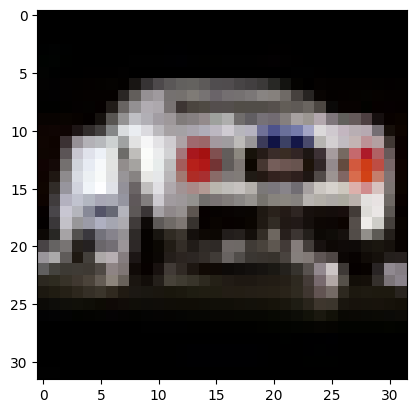

In [40]:
sample = chunks[0][5]
image = sample[:-1]
label = sample[-1]
image = image.reshape((32, 32, 3))

import matplotlib.pyplot as plt
plt.imshow(image)
